In [1]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(future)
library(Cairo)
library(DoubletFinder)
library(Matrix)
library(SeuratDisk)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



# mark doublet

## Pre-process

In [2]:
## read in file --------------------------------------------------------
# path to 10x directory
ipath = '/public21/home/sc90258/huangying/analysis/1.Aedes_scRNA-Seq/20231103_Aedes_midgut.2sp_rerun/1.cellranger_count/map_20231008_Aaedes_midgut_reanalysis/outs/filtered_feature_bc_matrix'
# 'project' in 'CreateSeuratObject'
project = 'Aedes_midgut'
# read in file
data10x = Read10X(
    data.dir = ipath
)
# make Seurat object of RNA data
# create Seurat object
seurat_obj =  CreateSeuratObject(
    counts = data10x, 
    assay = "RNA",
    project = project, 
    min.cells = 3
)

## filter out cells --------------------------------------------------------
min_nFeature_RNA = 100
# maximum nFeature_RNA
max_nFeature_RNA = 2500
# maximum percent.mt
max_percent.mt = 30

mt_genes_part = "AAEL018658|AAEL018659|AAEL018660|AAEL018661|AAEL018662|AAEL018663|AAEL018664|AAEL018665|AAEL018666|AAEL018667|AAEL018668|AAEL018669|AAEL018670|AAEL018671|AAEL018672|AAEL018673|AAEL018674|AAEL018675|AAEL018676|AAEL018677|AAEL018678|AAEL018679|AAEL018680|AAEL018681|AAEL018682|AAEL018683|AAEL018684|AAEL018685|AAEL018686|AAEL018687|AAEL018688|AAEL018689|AAEL018690|AAEL018691|AAEL018692|AAEL018693|AAEL018694|AAEL020667"
seurat_obj[["percent.mt"]] <- PercentageFeatureSet(
    seurat_obj,
    pattern = mt_genes_part,
    )
seurat_obj <- subset(
    seurat_obj, 
    subset = nFeature_RNA > as.numeric(min_nFeature_RNA) & nFeature_RNA < as.numeric(max_nFeature_RNA) & percent.mt < as.numeric(max_percent.mt),
)
seurat_obj_data <- GetAssayData(seurat_obj, assay = "RNA")
# remove MT genes
mt_genes = c("AAEL018658", "AAEL018659", "AAEL018660", "AAEL018661", "AAEL018662", "AAEL018663", "AAEL018664", "AAEL018665", "AAEL018666", "AAEL018667", "AAEL018668", "AAEL018669", "AAEL018670", "AAEL018671", "AAEL018672", "AAEL018673", "AAEL018674", "AAEL018675", "AAEL018676", "AAEL018677", "AAEL018678", "AAEL018679", "AAEL018680", "AAEL018681", "AAEL018682", "AAEL018683", "AAEL018684", "AAEL018685", "AAEL018686", "AAEL018687", "AAEL018688", "AAEL018689", "AAEL018690", "AAEL018691", "AAEL018692", "AAEL018693", "AAEL018694", "AAEL020667")
seurat_obj_data <- seurat_obj_data[
    -(which(rownames(seurat_obj_data) %in% c(mt_genes))),]
seurat_obj <- subset(seurat_obj, features = rownames(seurat_obj_data))

## do normalization --------------------------------------------------------
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)
# feature selection
# Identification of highly variable features
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
# scaling data
all.genes <- rownames(seurat_obj)
seurat_obj <- ScaleData(seurat_obj, features = all.genes)

## PCA reduce dimension ----------------------------------------------------
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj))
# runUMAP
seurat_obj <- RunUMAP(seurat_obj, dims = 1:50)

Centering and scaling data matrix

PC_ 1 
Positive:  AAEL022140, AAEL003530, AAEL022286, AAEL014583, AAEL013885, AAEL010168, AAEL011471, AAEL020749, AAEL011656, AAEL007715 
	   AAEL008481, AAEL002832, AAEL021083, AAEL012686, AAEL005629, AAEL005817, AAEL011447, AAEL003427, AAEL013625, AAEL020290 
	   AAEL002047, AAEL005266, AAEL014562, AAEL002372, AAEL000987, AAEL008103, AAEL001759, AAEL024434, AAEL005097, AAEL023681 
Negative:  AAEL025097, AAEL019553, AAEL007682, AAEL019426, AAEL019997, AAEL001843, AAEL008078, AAEL009114, AAEL021805, AAEL011359 
	   AAEL025552, AAEL019596, AAEL009294, AAEL024269, AAEL019863, AAEL019626, AAEL004572, AAEL019431, AAEL017224, AAEL018039 
	   AAEL019542, AAEL012539, AAEL019424, AAEL019982, AAEL023512, AAEL020547, AAEL019474, AAEL018139, AAEL021222, AAEL025268 
PC_ 2 
Positive:  AAEL027096, AAEL027514, AAEL007804, AAEL017445, AAEL018146, AAEL004583, AAEL003550, AAEL019926, AAEL013184, AAEL019406 
	   AAEL001915, AAEL007315, AAEL004193, AAEL006708, AAEL021581

In [3]:
# https://cloud.tencent.com/developer/article/1825672
nExp <- round(ncol(seurat_obj) * 0.04)  # expect 4% doublets
data.filt <- doubletFinder_v3(
    seurat_obj, 
    pN = 0.25, # https://cloud.tencent.com/developer/article/1825672
    pK = 0.09, 
    nExp = nExp, 
    PCs = 1:50)

Loading required package: fields

Loading required package: spam



Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:Matrix’:

    det


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridisLite


Try help(fields) to get started.

Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



[1] "Creating 971 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


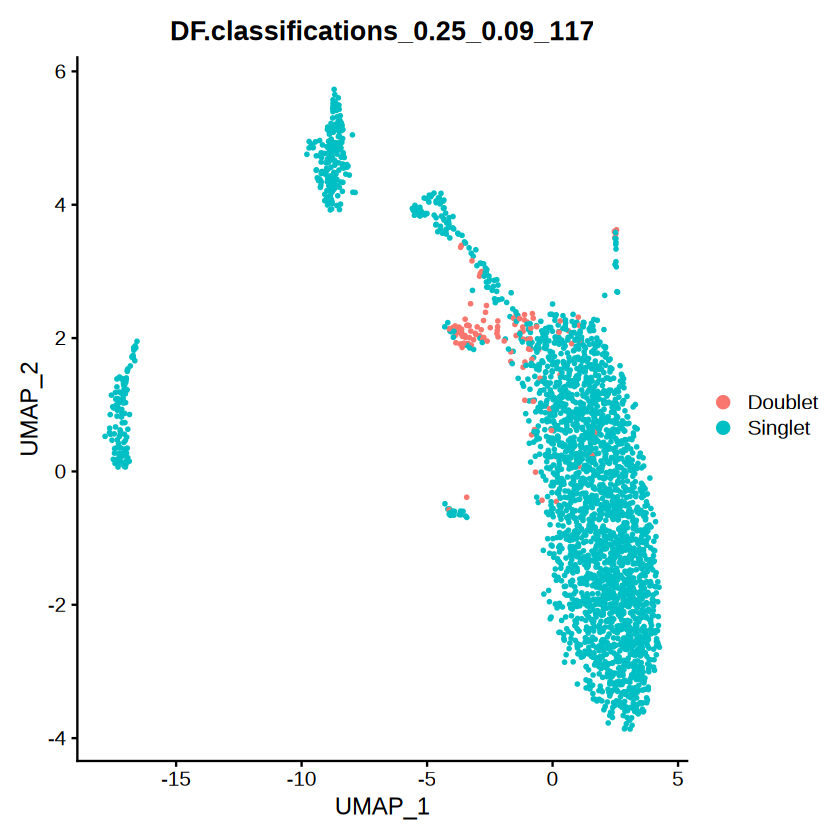

In [4]:
DF.name = colnames(data.filt@meta.data)[grepl("DF.classification", colnames(data.filt@meta.data))]

DimPlot(data.filt, group.by = DF.name)

In [5]:
# save seurat_obj
opath_seurat_obj = 'mark_doublet.seurat_obj.rds'
saveRDS(data.filt, file = opath_seurat_obj)
# write h5ad file
SaveH5Seurat(data.filt, filename = "mark_doublet.seurat_obj.h5Seurat")
Convert("mark_doublet.seurat_obj.h5Seurat", dest = "h5ad")

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

Adding variable features for RNA

Adding feature-level metadata for RNA

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Validating h5Seurat file

Adding scale.data from RNA as X

Transfering meta.features to var

Adding data from RNA as raw

Transfering meta.features to raw/var

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap

